In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
os.chdir('..')

In [3]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [4]:
def string_to_matrix(matrix_str):
    matrix_list = ast.literal_eval(matrix_str)
    return np.array(matrix_list)

def folds_to_ranks(folds):
    matrix_list = folds['lists'].tolist()
    matrix_stack = np.stack(matrix_list, axis=0)
    arr = np.mean(matrix_stack, axis=0)

    rank_epoch_accuracy = np.argsort(-arr.T[0])
    rank_epoch_overall = np.argsort(-arr.sum(axis=1))

    accuracy = arr[rank_epoch_accuracy[0]][0]
    listing = arr[rank_epoch_overall[0]]
    metric = sum(listing)
    listing = arr[rank_epoch_overall[0]]

    #best_fold_accs = [max([vec[0] for vec in mat]) for mat in matrix_stack]
    #best_fold_mets = [max([sum(vec) for vec in mat]) for mat in matrix_stack]

    per_move_acc_cross_folds = np.array([[vec[0] for vec in mat] for mat in matrix_stack]).T
    per_move_met_cross_folds = np.array([[sum(vec) for vec in mat] for mat in matrix_stack]).T

    acc_std_for_move = [np.std(move_stats) for move_stats in per_move_acc_cross_folds]
    met_std_for_move = [np.std(move_stats) for move_stats in per_move_met_cross_folds]

    return rank_epoch_accuracy, rank_epoch_overall, accuracy, metric, listing, acc_std_for_move, met_std_for_move

def agglomerate_folds(df):
    for i in range(len(df)//5):
        folds = df.iloc[5*i:5*(i+1),:]
        param_names = folds.iloc[0,:-2].index.tolist()
        params = folds.iloc[0,:-2].tolist()

        rank_epoch_accuracy, rank_epoch_overall, accuracy, metric, listing, acc_std_for_move, met_std_for_move = folds_to_ranks(folds)

        params.append(accuracy)
        param_names.append('best_accuracy')
        params.append(metric)
        param_names.append('best_metric')

        params.append(acc_std_for_move[rank_epoch_accuracy[0]])
        param_names.append('accuracy_std')
        params.append(met_std_for_move[rank_epoch_overall[0]])
        param_names.append('metric_std')

        params.append(rank_epoch_accuracy[0])
        param_names.append('acc_best_epoch')
        params.append(rank_epoch_overall[0])
        param_names.append('met_best_epoch')

        #params.append(np.std(best_fold_accs))
        #param_names.append('accuracy_std')
        #params.append(np.std(best_fold_mets))
        #param_names.append('metric_std')

        for j in range(3):
            params.append(rank_epoch_accuracy[j])
            param_names.append(f'#{j+1}_epoch_acc')
            params.append(rank_epoch_overall[j])
            param_names.append(f'#{j+1}_epoch_ovr')

        if i == 0:
            out_df = pd.DataFrame(columns=param_names)
        
        params.append(listing)
        param_names.append('dist_details')

        new_row = pd.DataFrame([params], columns=param_names)
        out_df = pd.concat([out_df, new_row], ignore_index=True)
    return out_df

In [5]:
def df_to_i_feature(df, feature):
    totes = len(df)
    variations = len(set(df[feature]))
    f_df = df[[feature, 'best_accuracy', 'best_metric', 'accuracy_std', 'metric_std', 'acc_best_epoch', 'met_best_epoch']].copy()
    f_df['config'] = [k for k in range(totes//variations)]*variations
    pivot_acc_df = f_df.pivot(index="config", columns=feature, values="best_accuracy")
    pivot_met_df = f_df.pivot(index="config", columns=feature, values="best_metric")

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(pivot_acc_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[0])
    ax[0].set_title(f'Heatmap of {feature} (Accuracy)')
    sns.heatmap(pivot_met_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
    ax[1].set_title(f'Heatmap of {feature} (Metric)')

    plt.show()

    f_ans = f_df.groupby(feature).mean()
    best_f_val = f_ans.index[np.argmax(f_ans.best_accuracy)]
    display(f_ans)

    best_df = df[df[feature]==best_f_val]
    epochs_df = best_df.iloc[:, -7:-1]
    display(epochs_df)

    return best_f_val


def df_to_xy_features(df, feature_x, feature_y):
    f_df = df[[feature_x, feature_y, 'best_accuracy', 'best_metric', 'accuracy_std', 'metric_std', 'acc_best_epoch', 'met_best_epoch']].copy()
    pivot_acc_df = f_df.pivot(index=feature_x, columns=feature_y, values="best_accuracy")
    pivot_met_df = f_df.pivot(index=feature_x, columns=feature_y, values="best_metric")

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(pivot_acc_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[0])
    ax[0].set_title(f'Heatmap of {feature_x} vs {feature_y} (Accuracy)')
    sns.heatmap(pivot_met_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
    ax[1].set_title(f'Heatmap of {feature_x} vs {feature_y} (Metric)')

    plt.show()

    layer_ans = f_df.groupby(feature_x).mean()
    best_x_val = layer_ans.index[np.argmax(layer_ans.best_accuracy)]
    display(layer_ans)

    alpha_ans = f_df.groupby(feature_y).mean()
    best_y_val = alpha_ans.index[np.argmax(alpha_ans.best_accuracy)]
    display(alpha_ans)

    return best_x_val, best_y_val

def lists_mat_to_acc(mat, epoch=40):
    return mat[epoch-1][0]

def col_group_folds(col):
    means = []
    stds = []
    for i in range(len(col)//5):
        folds = col[5*i:5*(i+1)]
        mean = np.mean(np.array(folds))
        std = np.std(np.array(folds))
        means.append(mean)
        stds.append(std)
    return means, stds

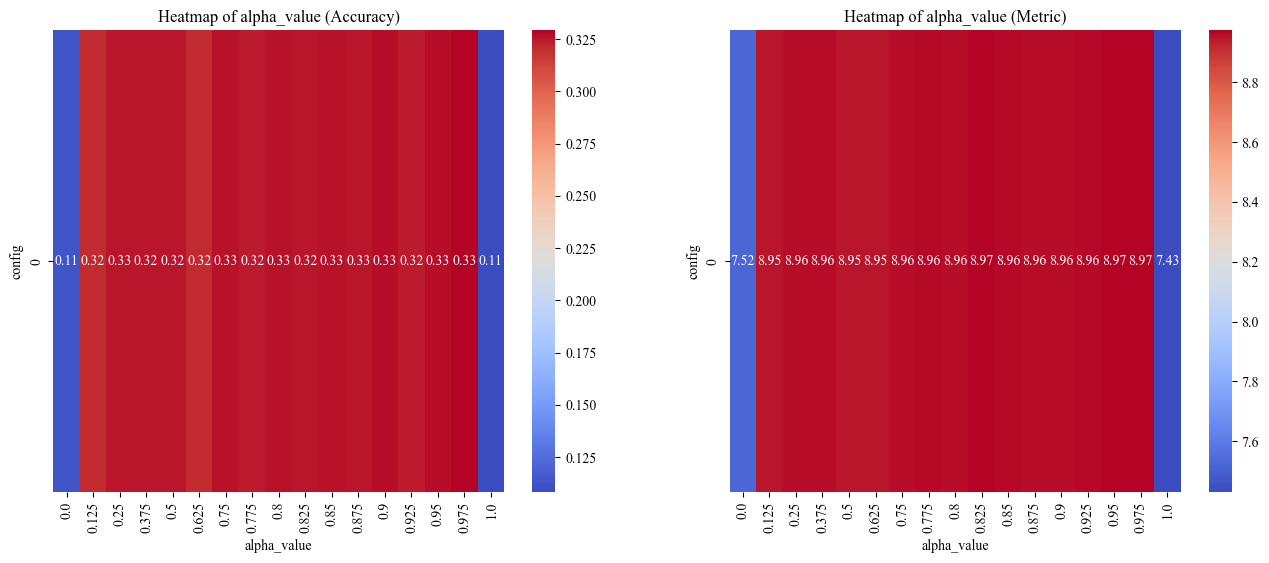

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
alpha_value,,,,,,,
0.000,0.11256,7.52066,0.012208,0.190198,32.0,5.0,0.0
0.125,0.32123,8.94552,0.004613,0.010792,29.0,22.0,0.0
0.250,0.32559,8.96078,0.005481,0.010716,23.0,23.0,0.0
0.375,0.32499,8.95561,0.002222,0.008342,27.0,26.0,0.0
0.500,0.32492,8.94785,0.005282,0.019138,26.0,26.0,0.0
0.625,0.32124,8.94583,0.002632,0.012375,25.0,30.0,0.0
0.750,0.32598,8.95883,0.004688,0.017881,23.0,17.0,0.0
0.775,0.32411,8.96242,0.003472,0.010472,30.0,28.0,0.0
0.800,0.32613,8.95931,0.006442,0.034394,23.0,26.0,0.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
15,27,22,25,25,24,27


alpha_value: 0.975


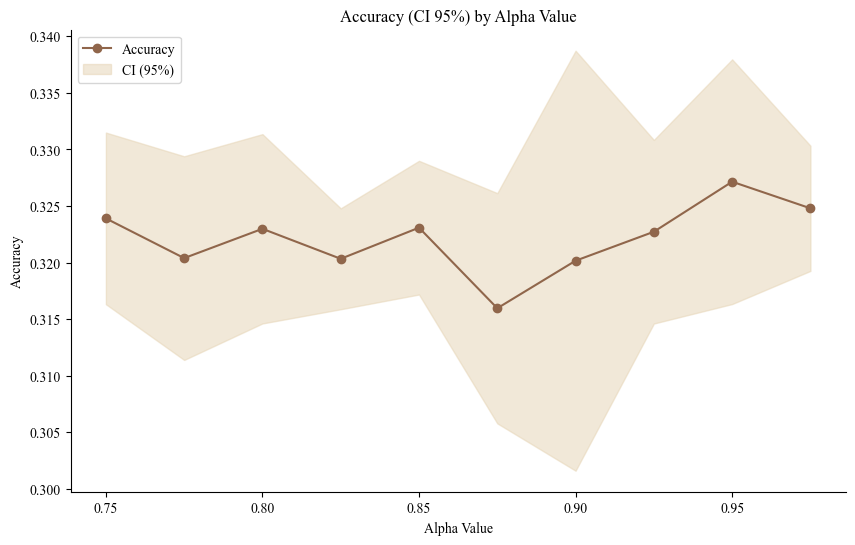

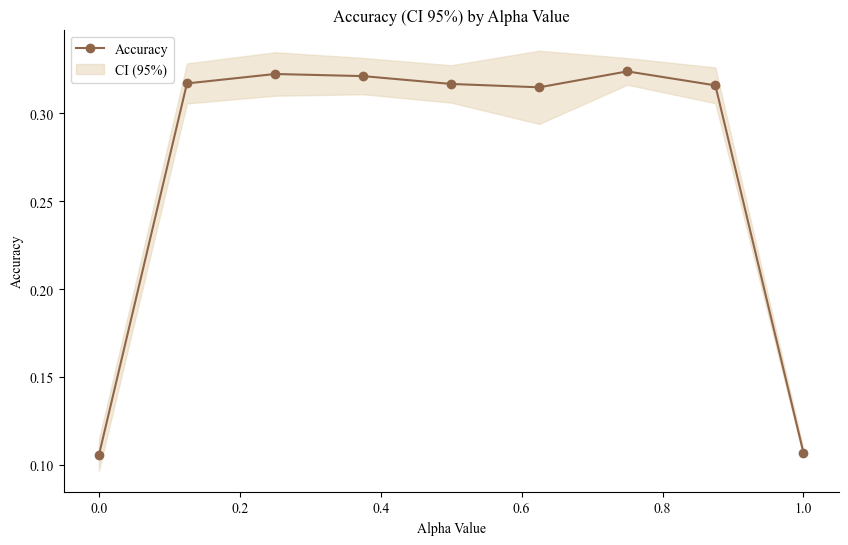

In [6]:
tuning_results_path = 'hyperparameter_tuning_results_2024-02-20-22_alpha.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'alpha_value'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

acc, std = col_group_folds(df['lists'].apply(lists_mat_to_acc))
acc, std = col_group_folds(df['lists'].apply(lambda x: lists_mat_to_acc(x, epoch=20)))

best_f_val = df_to_i_feature(out_df, feature)
print(f'{feature}: {best_f_val}')

sensitivity_df = agglomerate_folds(df).sort_values(by=feature)
sensitivity_df = sensitivity_df.loc[:,[feature]]

out_df['accuracy'] = acc
out_df['std'] = std

darkest_hex = "#90664b"
lightest_hex = "#e5d3b3"

sub_out = out_df.iloc[6:16,]
big_out = pd.concat([out_df.iloc[:7,], out_df.iloc[[11, 16]]]).reset_index(drop=True)

for df in [sub_out, big_out]:

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(df['alpha_value'], df['accuracy'], '-o', label='Accuracy', color = darkest_hex)

    ci_lower = df['accuracy'] - 1.96 * df['std']
    ci_upper = df['accuracy'] + 1.96 * df['std']
    ax.fill_between(df['alpha_value'], ci_lower, ci_upper, color=lightest_hex, alpha=0.5, label='CI (95%)')

    ax.set_xlabel('Alpha Value')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy (CI 95%) by Alpha Value')
    ax.legend(loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

In [7]:
dfs = []
params = ['batch_size','learning_rate','decay','sequence_length','hidden_size','num_layers','dropout_rate','alpha_value',]
#[10.867, 7.658, 2.397, 1.0, 1.0, 116.225, 116.225] seq len [50, 64, 80, 100, 128, 160, 200]
for feature in params:
    tuning_results_path = f'sensitivity_{feature}.csv'
    tuning_results_path = 'asset/csv/' + tuning_results_path

    df = pd.read_csv(tuning_results_path)
    df['lists'] = df['lists'].apply(string_to_matrix)
    acc, std = col_group_folds(df['lists'].apply(lists_mat_to_acc))
    sensitivity_df = agglomerate_folds(df).sort_values(by=feature)
    sensitivity_df = sensitivity_df.loc[:,[feature]]

    sensitivity_df['accuracy'] = acc
    sensitivity_df['std'] = std
    dfs.append(sensitivity_df)
    #display(sensitivity_df)

In [8]:
status_list = []
names_list = []
param_names = ['batch_size','learn_rate','decay','game_length','hidden_size','lstm_layers','dropout','loss_weight',]
benchmark_inds = [2 if param != 'num_layers' else 0 for param in params]
for i, sensitivity_df in enumerate(dfs):
    param = params[i]
    benchmark_index = benchmark_inds[i]
    bench_acc, bench_std = sensitivity_df.loc[benchmark_index].tolist()[1:]
    ci_lower = bench_acc - 1.96 * bench_std
    ci_upper = bench_acc + 1.96 * bench_std

    def in_or_std(row):
        if row['accuracy'] < ci_lower or row['accuracy'] > ci_upper:
            return abs(bench_acc - row['accuracy'])/bench_std
        else:
            return True
        
    status = []
    names =[]
    for row in sensitivity_df.iterrows():
        a = in_or_std(row[1])
        param_name = row[1].index[0]
        test_val = row[1][param]
        names.append(f'{param_names[i]}={test_val}')
        status.append(a)
    status_list.append(np.array(status))
    names_list.append(names)

In [9]:
annots = np.zeros_like(status_list).tolist()
colors_list = -np.cbrt(status_list)

for i, (ns, ss) in enumerate(zip(names_list, status_list)):
    for j, (n,s) in enumerate(zip(ns, ss)):
        if s == 1:
            annots[i][j] = n + '\n' + 'within 95% CI'
        else:
            annots[i][j] = n + '\n' + f'worse by {s:.2f} std'

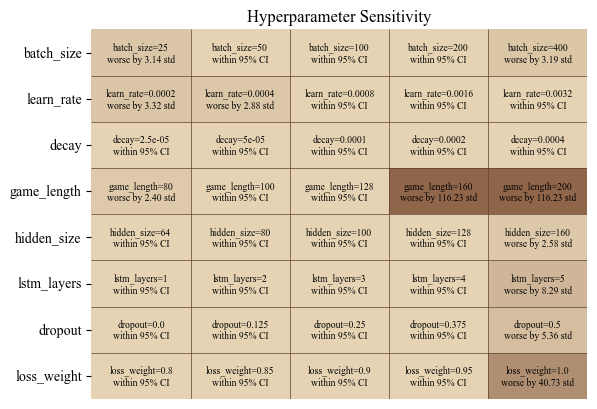

In [10]:
darkest_hex = "#90664b"
lightest_hex = "#e5d3b3"
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", [darkest_hex, lightest_hex])

ax = sns.heatmap(colors_list, annot=False, cmap=custom_cmap, cbar=False)
plt.title("Hyperparameter Sensitivity")
plt.xticks([])

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, verticalalignment='center', fontsize="10")
ax.set_yticklabels(param_names, rotation=0, verticalalignment='center')
ax.set_xlabel('')

for i in range(len(annots)):
    for j in range(len(annots[i])):
        ax.text(j + 0.5, i + 0.5, annots[i][j], 
                horizontalalignment='center', verticalalignment='center', 
                fontsize='x-small')
        
for i in range(1, len(colors_list) + 1):
    ax.hlines(i, *ax.get_xlim(), color='#5b402f', linestyles='solid', linewidth=0.5)
for j in range(1, len(colors_list[0]) + 1):
    ax.vlines(j, *ax.get_ylim(), color='#5b402f', linestyles='solid', linewidth=0.5)

plt.show()

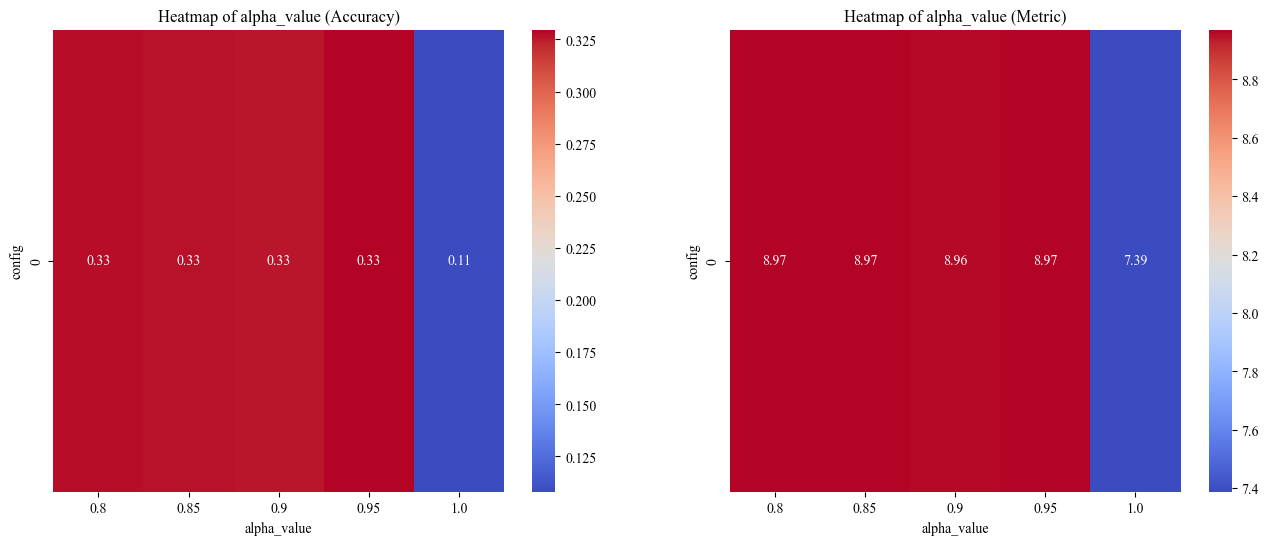

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
alpha_value,,,,,,,
0.80,0.32774,8.96549,0.004409,0.019366,36.0,29.0,0.0
0.85,0.32650,8.96858,0.005493,0.012688,32.0,34.0,0.0
0.90,0.32586,8.95917,0.003259,0.015619,38.0,31.0,0.0
0.95,0.32963,8.97022,0.002389,0.007055,35.0,35.0,0.0
1.00,0.10810,7.38831,0.000977,0.002103,37.0,26.0,0.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
3,35,35,38,39,37,37


alpha_value: 0.95


In [11]:
tuning_results_path = f'sensitivity_{param}.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = param

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

#best_f_val = df_to_i_feature(out_df.loc[:len(out_df)-2], feature)
best_f_val = df_to_i_feature(out_df, feature)

print(f'{feature}: {best_f_val}')

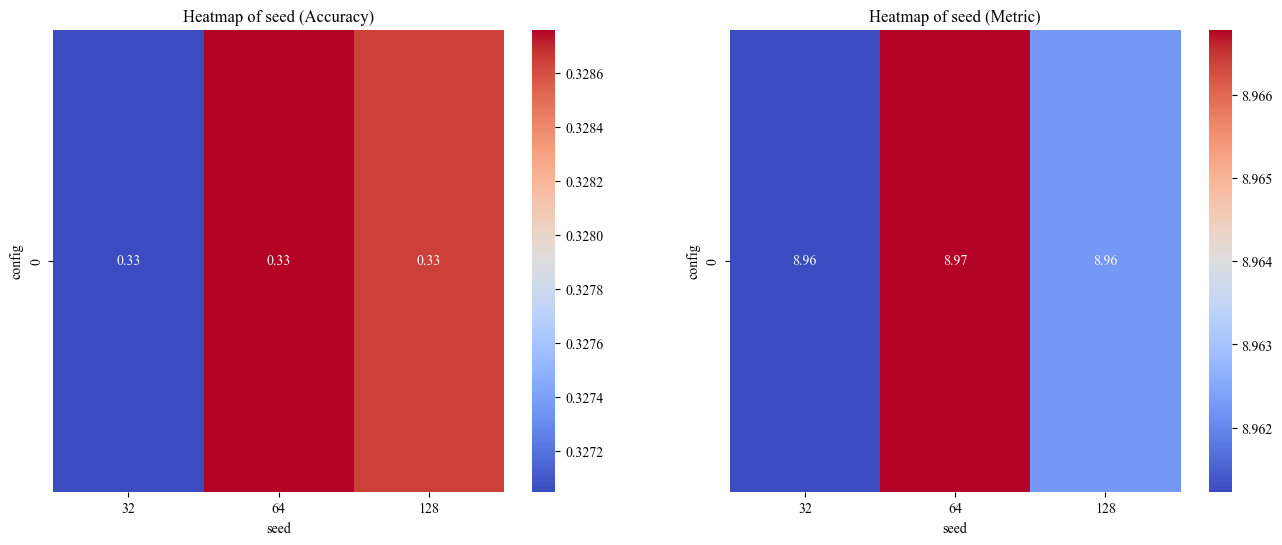

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
seed,,,,,,,
32,0.32705,8.96123,0.002745,0.009544,38.0,39.0,0.0
64,0.32876,8.96678,0.001944,0.008999,40.0,39.0,0.0
128,0.32864,8.96224,0.003350,0.015241,39.0,34.0,0.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
1,40,39,39,32,43,31


seed: 64


In [12]:
tuning_results_path = 'hyperparameter_tuning_results_seed.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'seed'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

#best_f_val = df_to_i_feature(out_df.loc[1:len(out_df)-2], feature)
best_f_val = df_to_i_feature(out_df, feature)

print(f'{feature}: {best_f_val}')

In [13]:
out_df

,seed,decay,dropout_rate,alpha_value,hidden_size,num_layers,learning_rate,batch_size,sequence_length,best_accuracy,...,metric_std,acc_best_epoch,met_best_epoch,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr,dist_details
0,32,0.0001,0,0.9,100,3,0.0008,100,128,0.32705,...,0.009544,38,39,38,39,34,38,45,36,"[0.32267, 0.7492599999999999, 0.92022999999999..."
1,64,0.0001,0,0.9,100,3,0.0008,100,128,0.32876,...,0.008999,40,39,40,39,39,32,43,31,"[0.32857, 0.7485999999999999, 0.92021, 0.97736..."
2,128,0.0001,0,0.9,100,3,0.0008,100,128,0.32864,...,0.015241,39,34,39,34,45,31,35,41,"[0.32681, 0.74774, 0.9191900000000001, 0.97664..."


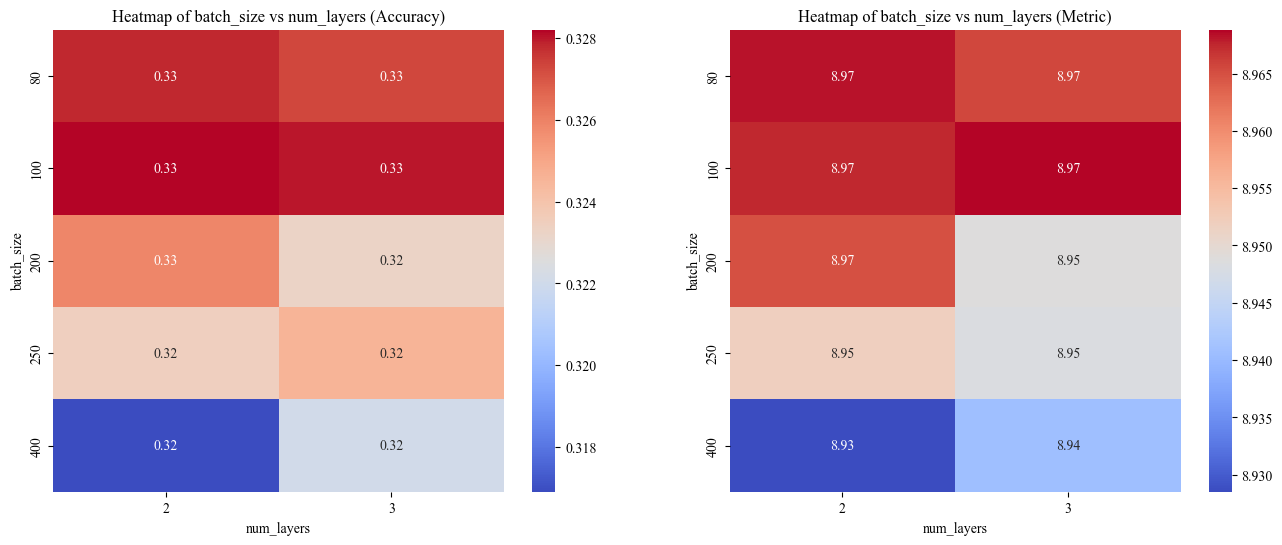

,num_layers,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
batch_size,,,,,,,
80,2.5,0.32756,8.966945,0.003597,0.011900,35.5,35.5
100,2.5,0.32811,8.968155,0.003976,0.014029,34.0,30.5
200,2.5,0.32455,8.956885,0.003173,0.012943,41.0,40.5
250,2.5,0.32401,8.950145,0.004160,0.020396,38.0,38.0
400,2.5,0.31948,8.934635,0.003208,0.009152,40.0,40.0


,batch_size,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
num_layers,,,,,,,
2,206.0,0.324456,8.956264,0.003136,0.011457,36.4,36.4
3,206.0,0.325028,8.954442,0.004109,0.015911,39.0,37.4


batch_size: 100
num_layers: 3


In [14]:
tuning_results_path = 'hyperparameter_tuning_results_batch_lay.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature_x = 'batch_size'
feature_y = 'num_layers'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

In [15]:
out_df

,decay,dropout_rate,alpha_value,hidden_size,num_layers,learning_rate,batch_size,sequence_length,best_accuracy,best_metric,...,metric_std,acc_best_epoch,met_best_epoch,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr,dist_details
0,0.0001,0,0.9,100,2,0.0008,80,128,0.32781,8.96832,...,0.012005,38,38,38,38,34,33,33,39,"[0.32781000000000005, 0.7489800000000001, 0.92..."
1,0.0001,0,0.9,100,2,0.0008,100,128,0.32820,8.96748,...,0.010436,27,27,27,27,32,39,33,32,"[0.3282, 0.74859, 0.9192, 0.97835, 0.994599999..."
2,0.0001,0,0.9,100,2,0.0008,200,128,0.32588,8.96505,...,0.010018,41,41,41,41,34,35,38,38,"[0.32588, 0.74729, 0.9205400000000001, 0.97854..."
3,0.0001,0,0.9,100,3,0.0008,80,128,0.32731,8.96557,...,0.011795,33,33,33,33,41,36,39,40,"[0.32731, 0.74709, 0.92014, 0.9782, 0.99457000..."
4,0.0001,0,0.9,100,3,0.0008,100,128,0.32802,8.96883,...,0.017622,41,34,41,34,34,32,40,41,"[0.32689, 0.7498000000000001, 0.92114, 0.97835..."
5,0.0001,0,0.9,100,3,0.0008,200,128,0.32322,8.94872,...,0.015867,41,40,41,40,40,36,39,41,"[0.32276, 0.74082, 0.91605, 0.97668, 0.9941000..."
6,0.0001,0,0.9,100,2,0.0008,250,128,0.32348,8.95196,...,0.015734,36,36,36,36,38,38,40,40,"[0.32348000000000005, 0.74285, 0.9167500000000..."
7,0.0001,0,0.9,100,2,0.0008,400,128,0.31691,8.92851,...,0.009090,40,40,40,40,39,41,35,39,"[0.31691, 0.7321099999999999, 0.91174, 0.97544..."
8,0.0001,0,0.9,100,3,0.0008,250,128,0.32454,8.94833,...,0.025058,40,40,40,40,38,37,36,36,"[0.32454, 0.73964, 0.91561, 0.9764200000000001..."
9,0.0001,0,0.9,100,3,0.0008,400,128,0.32205,8.94076,...,0.009215,40,40,40,40,41,39,39,41,"[0.32205, 0.7366199999999999, 0.91311999999999..."


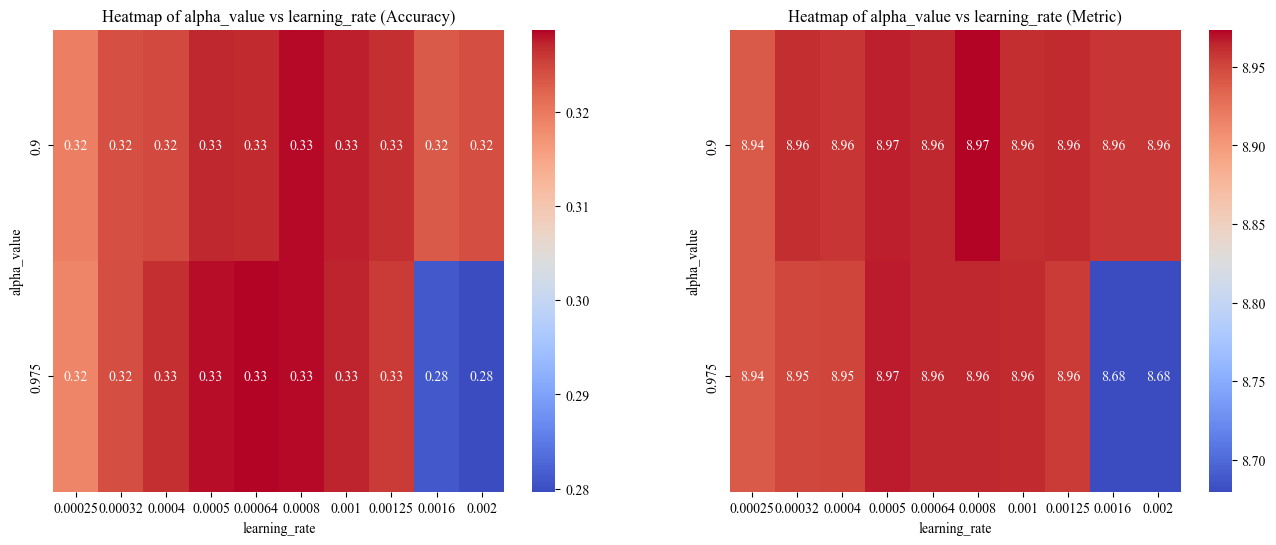

,learning_rate,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
alpha_value,,,,,,,
0.900,0.000876,0.325173,8.960271,0.003453,0.014325,34.5,32.1
0.975,0.000876,0.316859,8.901581,0.019461,0.120719,34.1,32.3


,alpha_value,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
learning_rate,,,,,,,
0.00025,0.9375,0.319065,8.939715,0.002918,0.007121,41.0,41.0
0.00032,0.9375,0.324135,8.955625,0.003020,0.015844,37.0,38.0
0.00040,0.9375,0.325525,8.954835,0.004712,0.011593,37.0,36.0
0.00050,0.9375,0.327670,8.967025,0.002352,0.014791,39.5,38.0
0.00064,0.9375,0.327805,8.963875,0.003104,0.016899,38.0,35.5
0.00080,0.9375,0.328385,8.969005,0.003588,0.017667,34.0,36.0
0.00100,0.9375,0.327380,8.962130,0.002814,0.013362,30.5,27.5
0.00125,0.9375,0.326110,8.959050,0.001558,0.019500,32.5,23.0
0.00160,0.9375,0.302110,8.818880,0.046971,0.280139,29.5,21.5


alpha_value: 0.9
learning_rate: 0.0008


In [16]:
tuning_results_path = 'hyperparameter_tuning_results_0223_lr.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature_x = 'alpha_value'
feature_y = 'learning_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

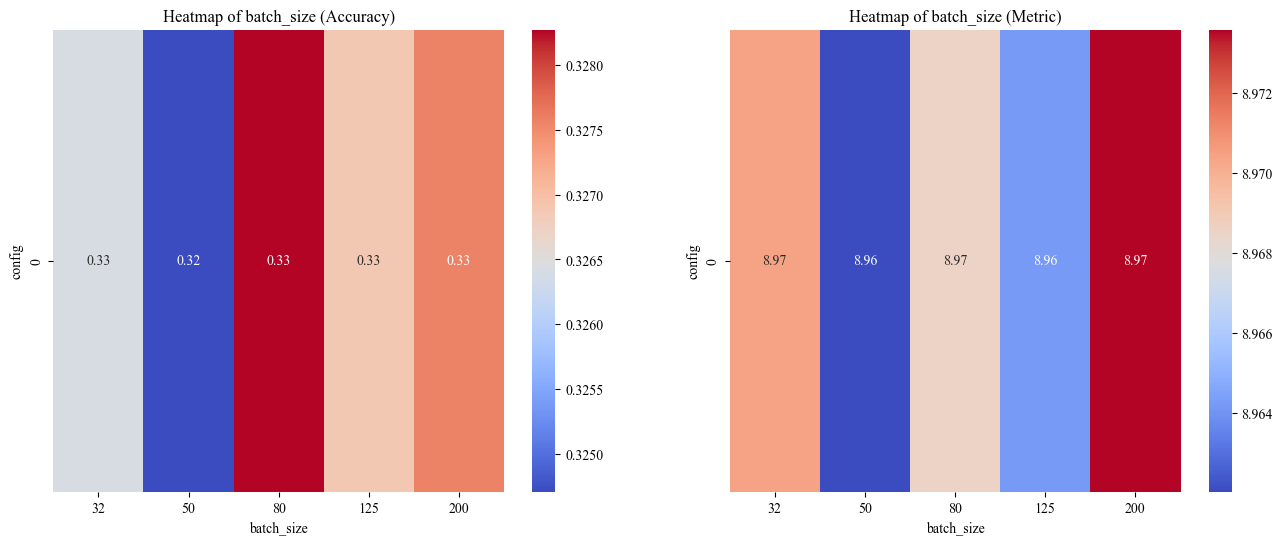

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
batch_size,,,,,,,
32,0.32641,8.97039,0.003516,0.008554,26.0,26.0,0.0
50,0.32471,8.96202,0.005153,0.009849,25.0,25.0,0.0
80,0.32827,8.96854,0.002889,0.009256,26.0,26.0,0.0
125,0.32688,8.96421,0.003913,0.012469,38.0,35.0,0.0
200,0.32757,8.97357,0.005186,0.011891,41.0,41.0,0.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
2,26,26,35,23,20,20


batch_size: 80


In [17]:
feature = 'batch_size'
tuning_results_path = f'Sensitivity_{feature}s.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)
#best_f_val = df_to_i_feature(out_df.loc[1:len(out_df)-2], feature)

print(f'{feature}: {best_f_val}')

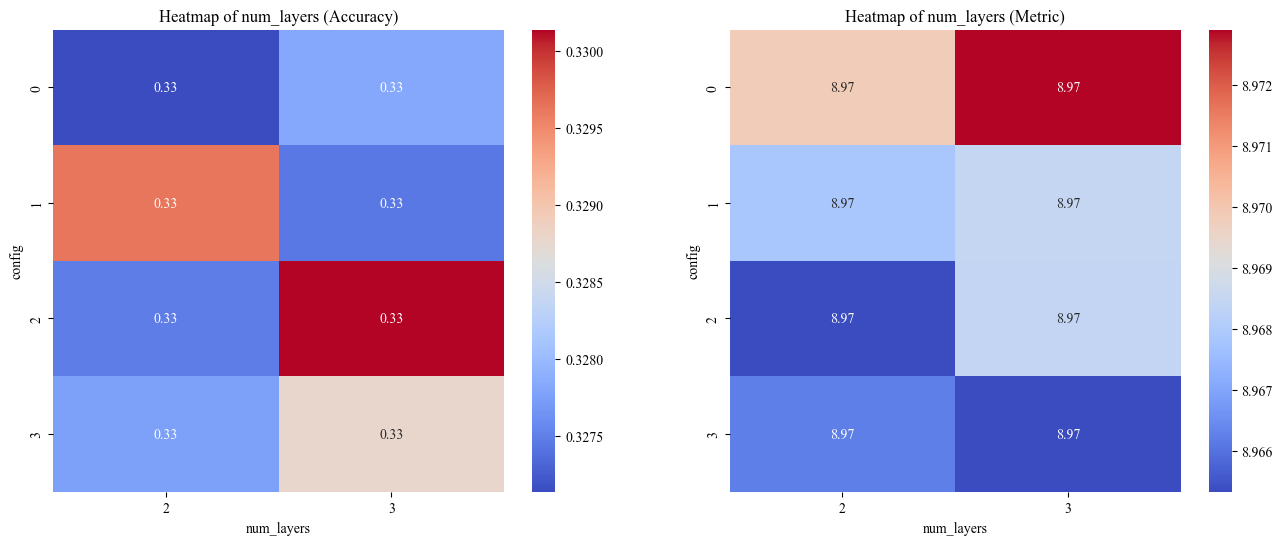

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
num_layers,,,,,,,
2,0.328002,8.967315,0.003798,0.007691,25.5,25.75,1.5
3,0.328550,8.968787,0.003679,0.009615,28.75,25.0,1.5


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
1,31,25,25,24,30,30
3,29,27,30,28,28,23
5,24,24,25,23,27,27
7,31,24,22,23,26,31


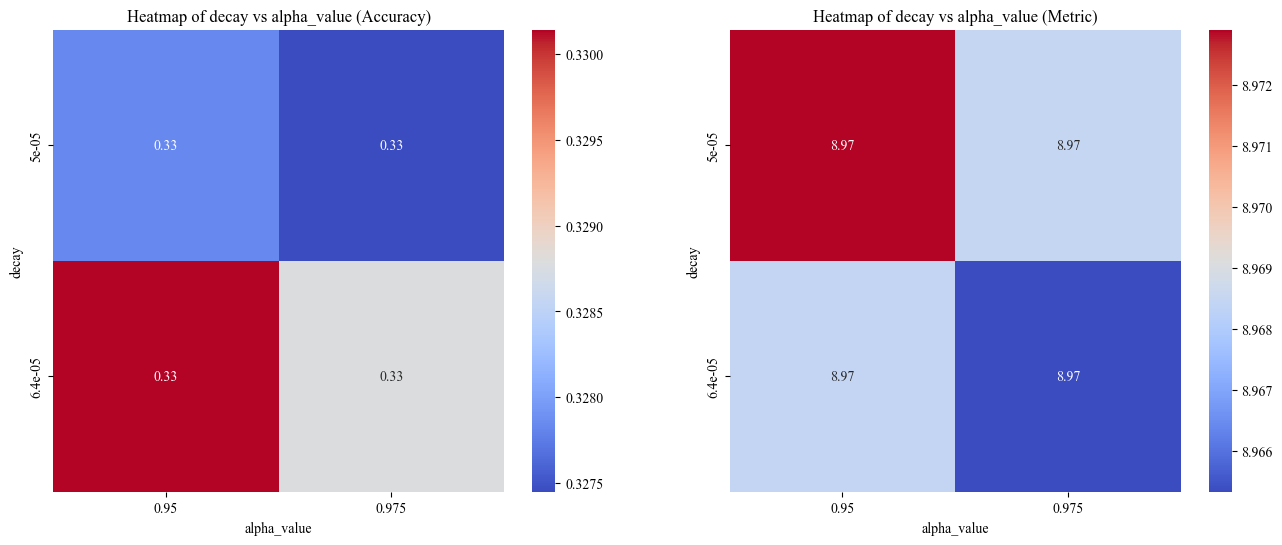

,alpha_value,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
decay,,,,,,,
0.000050,0.9625,0.32764,8.970685,0.004697,0.00802,30.0,26.0
0.000064,0.9625,0.32946,8.966890,0.002661,0.01121,27.5,24.0


,decay,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
alpha_value,,,,,,,
0.950,0.000057,0.328985,8.970675,0.002488,0.008971,27.5,24.5
0.975,0.000057,0.328115,8.966900,0.004870,0.010260,30.0,25.5


num_layers: 3
decay: 6.4e-05
alpha_value: 0.95


In [18]:
tuning_results_path = 'hyperparameter_tuning_results_2024-02-21-07_reg_a_lay.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'num_layers'
feature_x = 'decay'
feature_y = 'alpha_value'
feature_bad = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)

bad_dict = {}
bad_dict['dropout_rate_bad'] = 0.05
bad_dict['alpha_value_bad'] = 0.975
bad_dict['num_layers_bad'] = 3
bad_dict['decay_bad'] = 0.000050
key = feature_bad + '_bad'
bad_val = bad_dict[key]

df = df[df[feature_bad]!=bad_val] #remove bad

out_df = agglomerate_folds(df).sort_values(by=feature)


best_f_val = df_to_i_feature(out_df, feature)
select_df = out_df[out_df[feature]==best_f_val]

best_x_val, best_y_val = df_to_xy_features(select_df, feature_x, feature_y)

print(f'{feature}: {best_f_val}')
print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

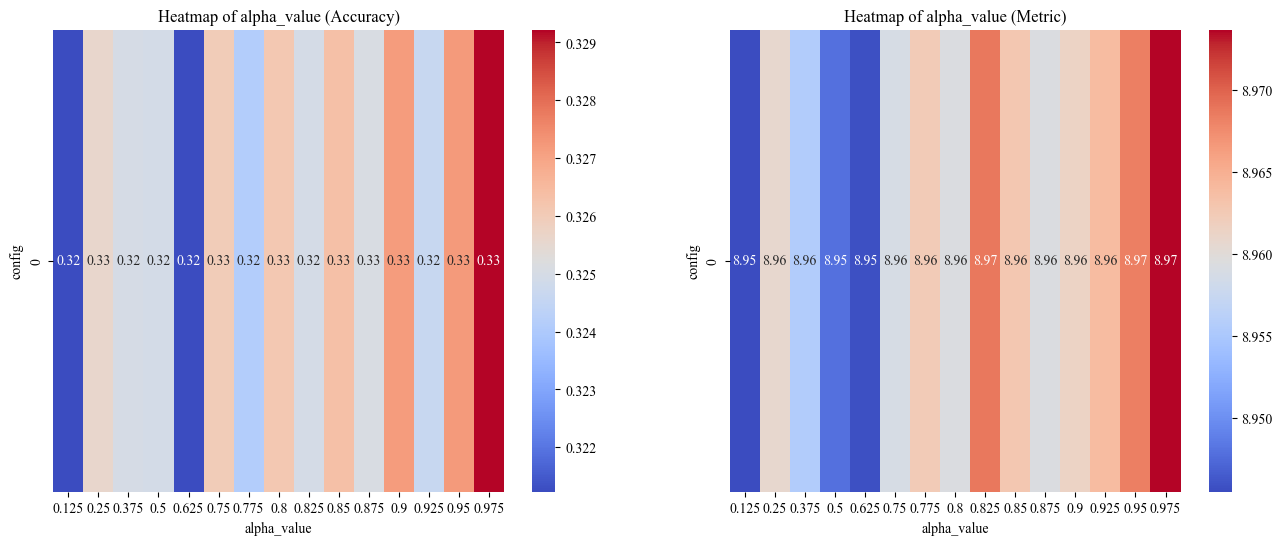

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
alpha_value,,,,,,,
0.125,0.32123,8.94552,0.004613,0.010792,29.0,22.0,0.0
0.250,0.32559,8.96078,0.005481,0.010716,23.0,23.0,0.0
0.375,0.32499,8.95561,0.002222,0.008342,27.0,26.0,0.0
0.500,0.32492,8.94785,0.005282,0.019138,26.0,26.0,0.0
0.625,0.32124,8.94583,0.002632,0.012375,25.0,30.0,0.0
0.750,0.32598,8.95883,0.004688,0.017881,23.0,17.0,0.0
0.775,0.32411,8.96242,0.003472,0.010472,30.0,28.0,0.0
0.800,0.32613,8.95931,0.006442,0.034394,23.0,26.0,0.0
0.825,0.32497,8.96875,0.001658,0.006613,30.0,21.0,0.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
15,27,22,25,25,24,27


alpha_value: 0.975


In [19]:
tuning_results_path = 'hyperparameter_tuning_results_2024-02-20-22_alpha.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'alpha_value'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df.loc[1:len(out_df)-2], feature)
#best_f_val = df_to_i_feature(out_df, feature)

print(f'{feature}: {best_f_val}')

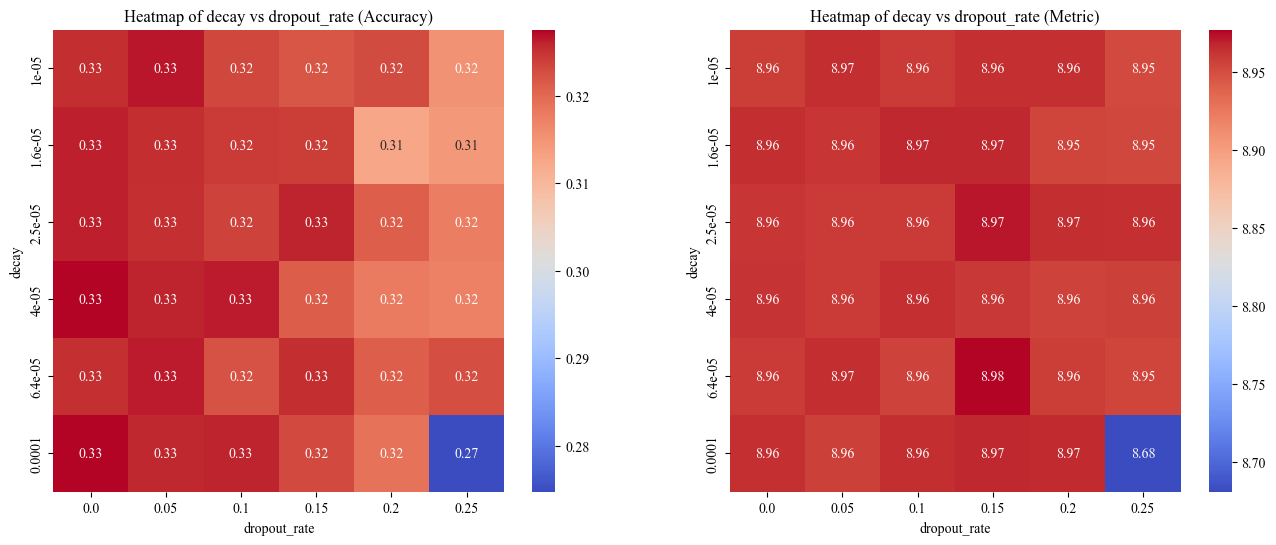

,dropout_rate,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
decay,,,,,,,
0.000010,0.125,0.322537,8.960615,0.003325,0.009181,27.5,23.166667
0.000016,0.125,0.321175,8.961353,0.004804,0.009830,27.666667,27.333333
0.000025,0.125,0.323312,8.963642,0.004775,0.014808,29.166667,28.166667
0.000040,0.125,0.322758,8.959765,0.004890,0.011884,26.666667,27.0
0.000064,0.125,0.323860,8.961685,0.003464,0.009071,30.5,32.166667
0.000100,0.125,0.315993,8.916507,0.016287,0.102500,33.333333,30.166667


,decay,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
dropout_rate,,,,,,,
0.00,0.000043,0.326315,8.961578,0.003663,0.012801,29.333333,26.166667
0.05,0.000043,0.325908,8.961322,0.003844,0.013588,28.166667,23.5
0.10,0.000043,0.324387,8.961893,0.003411,0.010017,30.833333,27.666667
0.15,0.000043,0.323582,8.967907,0.003323,0.010578,26.666667,28.5
0.20,0.000043,0.319068,8.960555,0.004258,0.008660,30.833333,30.333333
0.25,0.000043,0.310375,8.910312,0.019046,0.101628,29.0,31.833333


decay: 6.4e-05
dropout_rate: 0.0


In [20]:
tuning_results_path = 'hyperparameter_tuning_results_0221_reg_tune.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature_x = 'decay'
feature_y = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

In [21]:
mets = set(out_df.sort_values(by='best_metric', ascending=False).index[:8])
accs = set(out_df.sort_values(by='best_accuracy', ascending=False).index[:8])
out_df.loc[[i for i in mets if i in accs]]

,decay,dropout_rate,alpha_value,hidden_size,num_layers,learning_rate,batch_size,sequence_length,best_accuracy,best_metric,...,metric_std,acc_best_epoch,met_best_epoch,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr,dist_details
1,0.000010,0.05,0.875,100,3,0.001,80,128,0.32654,8.96546,...,0.009694,25,19,25,19,19,25,23,22,"[0.32504000000000005, 0.7480499999999999, 0.92..."
25,0.000064,0.05,0.875,100,3,0.001,80,128,0.32648,8.96546,...,0.012315,28,26,28,26,30,28,27,30,"[0.32438, 0.74701, 0.9221600000000001, 0.97855..."


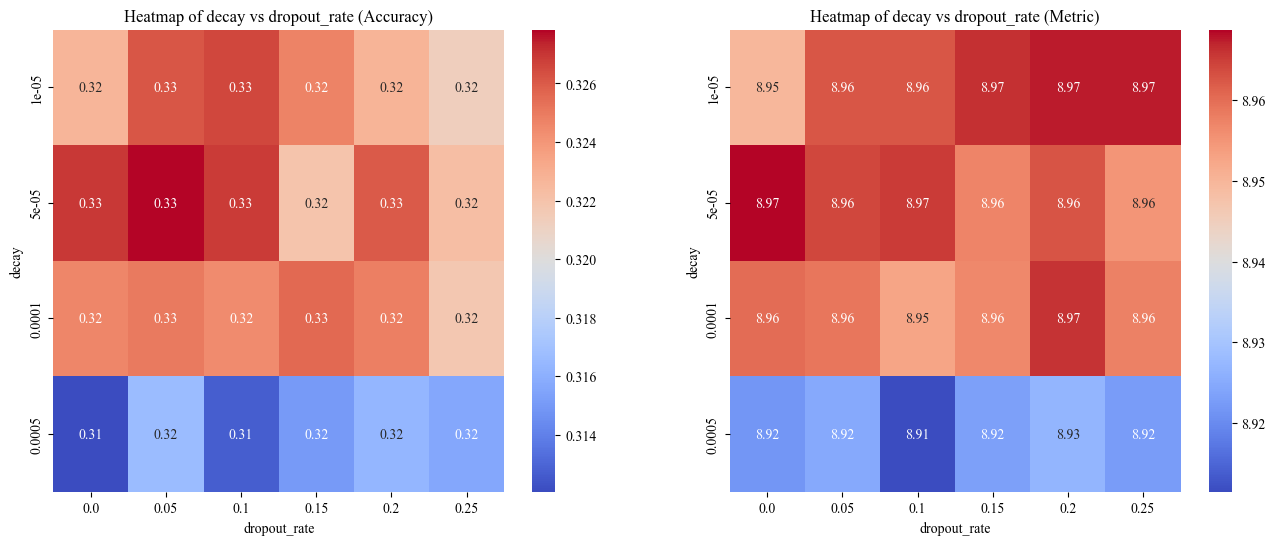

,dropout_rate,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
decay,,,,,,,
0.00001,0.125,0.324040,8.962703,0.003949,0.012543,36.166667,38.833333
0.00005,0.125,0.325315,8.962225,0.004637,0.012955,38.5,37.833333
0.00010,0.125,0.324377,8.958720,0.004652,0.011245,38.333333,37.833333
0.00050,0.125,0.314733,8.921718,0.004157,0.015420,39.666667,38.333333


,decay,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
dropout_rate,,,,,,,
0.00,0.000165,0.321575,8.950093,0.004358,0.013249,40.25,38.5
0.05,0.000165,0.323908,8.952655,0.003767,0.010944,38.0,38.25
0.10,0.000165,0.322638,8.947980,0.004194,0.014755,38.25,37.25
0.15,0.000165,0.321837,8.950917,0.004671,0.015273,37.0,36.25
0.20,0.000165,0.322503,8.955735,0.005012,0.010563,37.0,39.75
0.25,0.000165,0.320238,8.950670,0.004091,0.013461,38.5,39.25


decay: 5e-05
dropout_rate: 0.05


In [22]:
tuning_results_path = 'hyperparameter_tuning_results_0220_reg.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature_x = 'decay'
feature_y = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

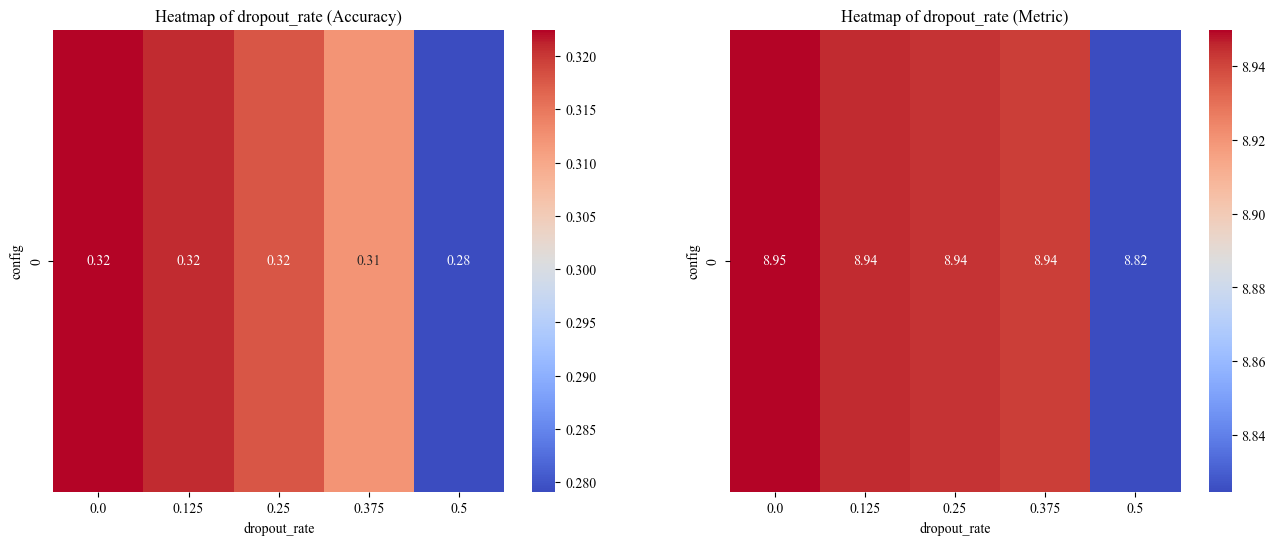

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
dropout_rate,,,,,,,
0.000,0.32247,8.94985,0.001084,0.015694,28.0,30.0,0.0
0.125,0.32082,8.94497,0.004847,0.015660,31.0,27.0,0.0
0.250,0.31787,8.94367,0.004612,0.017756,31.0,31.0,0.0
0.375,0.31222,8.94160,0.010765,0.017638,30.0,28.0,0.0
0.500,0.27909,8.82464,0.029587,0.172167,21.0,30.0,0.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
0,28,30,29,28,25,26


dropout_rate: 0.0


In [23]:
tuning_results_path = 'hyperparameter_tuning_results_2024-02-20-02_dropout.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)

print(f'{feature}: {best_f_val}')

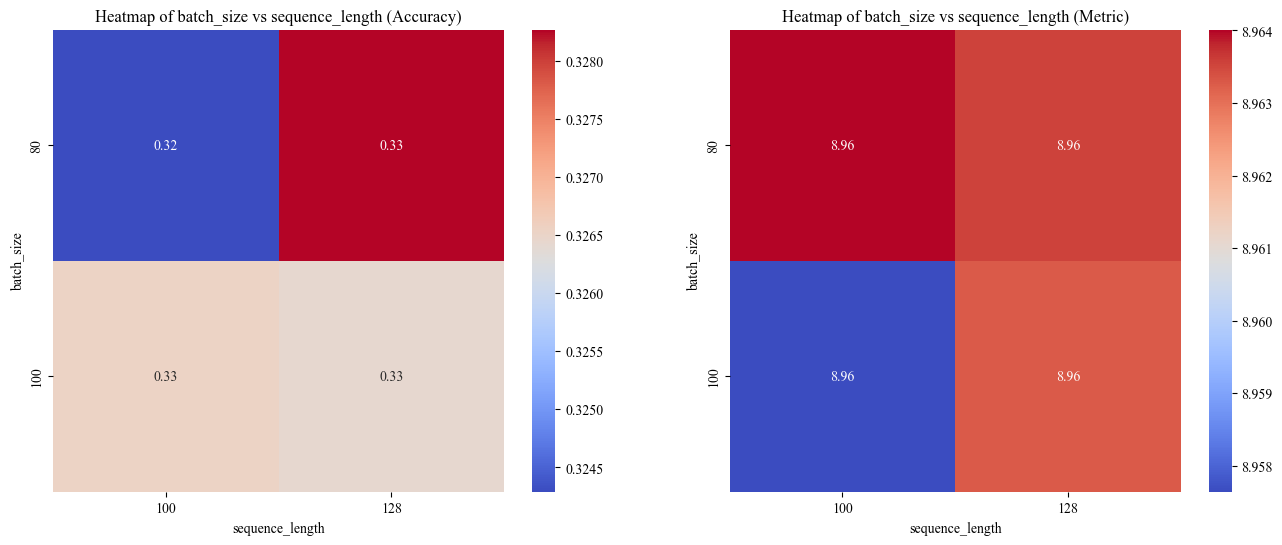

,sequence_length,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
batch_size,,,,,,,
80,114.0,0.326280,8.963780,0.003625,0.012551,32.0,32.0
100,114.0,0.326485,8.960455,0.004689,0.016531,29.5,33.0


,batch_size,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
sequence_length,,,,,,,
100,90.0,0.325415,8.960825,0.003744,0.018862,31.5,30.5
128,90.0,0.327350,8.963410,0.004570,0.010221,30.0,34.5


batch_size: 100
sequence_length: 128


In [24]:
tuning_results_path = 'hyperparameter_tuning_results_ba_se_100.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature_x = 'batch_size'
feature_y = 'sequence_length'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

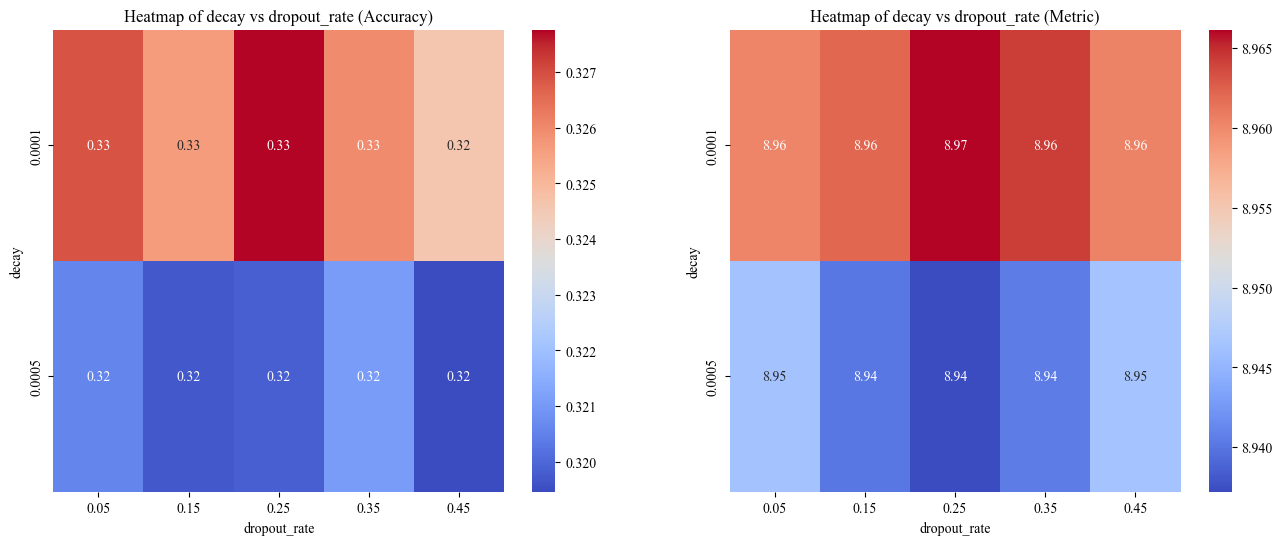

,dropout_rate,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
decay,,,,,,,
0.0001,0.25,0.326174,8.962690,0.004200,0.014735,30.4,29.4
0.0005,0.25,0.320126,8.942102,0.003261,0.013832,39.2,35.8


,decay,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
dropout_rate,,,,,,,
0.05,0.0003,0.323740,8.953370,0.004010,0.019663,40.0,35.5
0.15,0.0003,0.322670,8.951120,0.004220,0.013069,36.0,35.0
0.25,0.0003,0.323800,8.951685,0.001292,0.015256,34.5,31.0
0.35,0.0003,0.323505,8.952385,0.004251,0.013250,32.5,28.5
0.45,0.0003,0.322035,8.953420,0.004879,0.010180,31.0,33.0


decay: 0.0001
dropout_rate: 0.25


In [25]:
tuning_results_path = 'hyperparameter_tuning_results_0218_reg_lay3.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature_x = 'decay'
feature_y = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

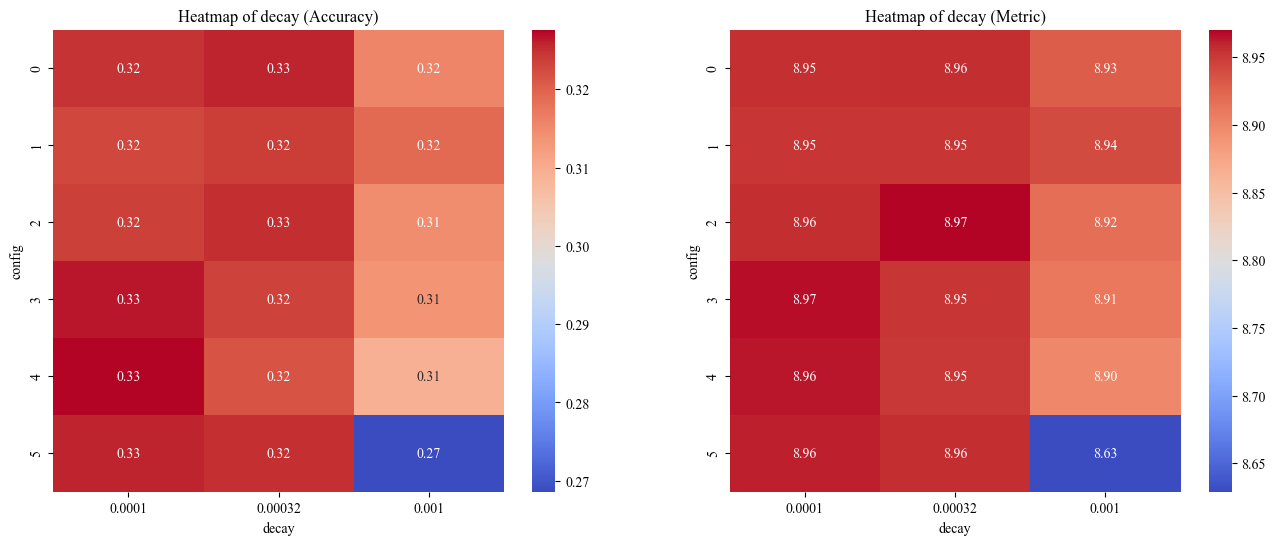

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
decay,,,,,,,
0.00010,0.325227,8.959320,0.004073,0.011128,30.0,29.666667,2.5
0.00032,0.324052,8.956178,0.003704,0.015615,35.5,38.5,2.5
0.00100,0.306873,8.870802,0.016796,0.102917,36.666667,31.666667,2.5


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
0,34,24,24,28,28,25
1,27,32,28,28,29,29
2,27,32,28,26,32,27
3,27,27,31,32,32,30
4,31,30,30,24,26,26
5,34,33,29,31,33,21


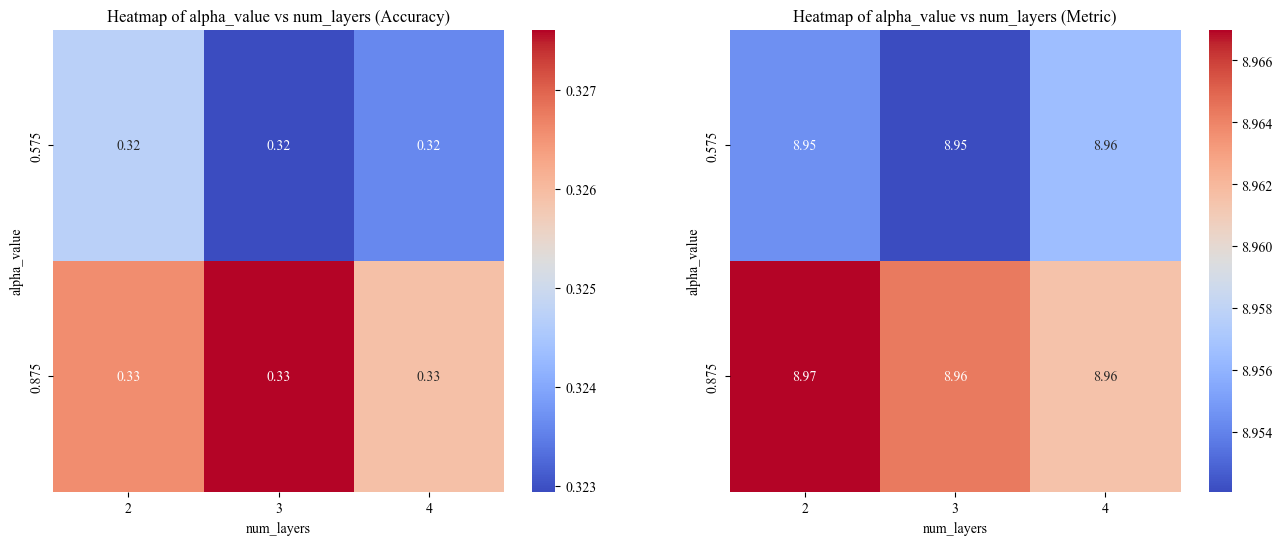

,num_layers,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
alpha_value,,,,,,,
0.575,3.0,0.323750,8.95437,0.003935,0.012227,29.333333,29.333333
0.875,3.0,0.326703,8.96427,0.004211,0.010030,30.666667,30.0


,alpha_value,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
num_layers,,,,,,,
2,0.725,0.325645,8.960735,0.003812,0.010189,30.5,25.5
3,0.725,0.325275,8.958220,0.004143,0.008587,29.0,31.0
4,0.725,0.324760,8.959005,0.004265,0.014609,30.5,32.5


decay: 0.0001
alpha_value: 0.875
num_layers: 2


In [26]:
tuning_results_path = 'hyperparameter_tuning_results_2024-02-18-04_decay_a_lay.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'decay'
feature_x = 'alpha_value'
feature_y = 'num_layers'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)
select_df = out_df[out_df[feature]==best_f_val]

best_x_val, best_y_val = df_to_xy_features(select_df, feature_x, feature_y)

print(f'{feature}: {best_f_val}')
print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

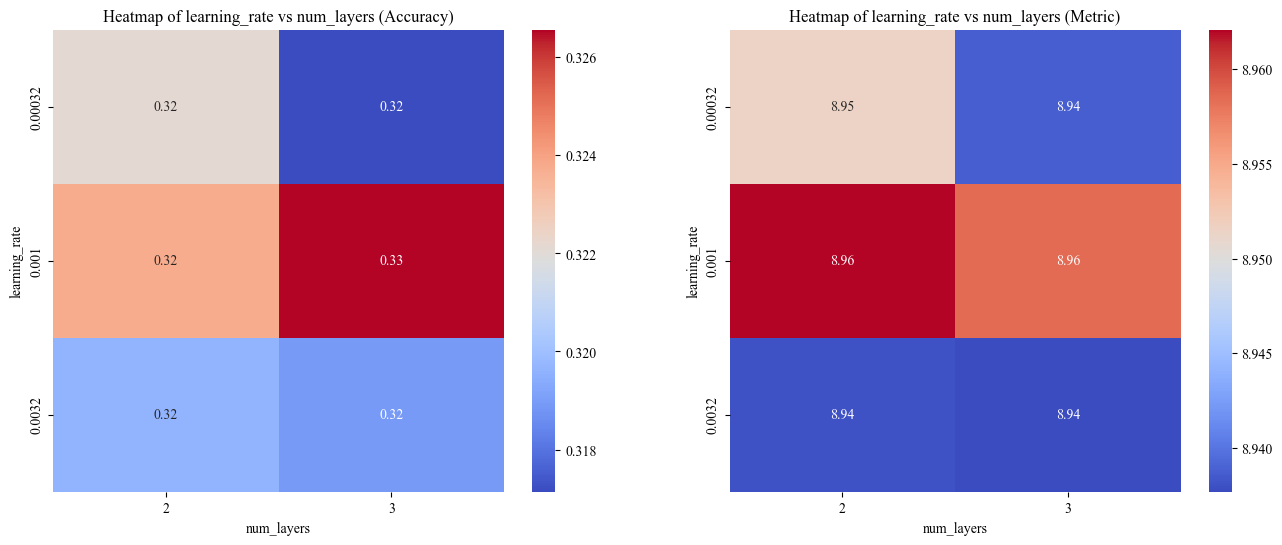

,num_layers,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
learning_rate,,,,,,,
0.00032,2.5,0.319625,8.945055,0.005860,0.015207,39.5,40.0
0.00100,2.5,0.325145,8.960325,0.003284,0.007036,30.5,28.0
0.00320,2.5,0.319275,8.937850,0.005090,0.025255,34.0,22.5


,learning_rate,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
num_layers,,,,,,,
2,0.001507,0.321823,8.950507,0.005349,0.015664,31.333333,27.666667
3,0.001507,0.320873,8.944980,0.004140,0.016002,38.0,32.666667


learning_rate: 0.001
num_layers: 2


In [27]:
tuning_results_path = 'hyperparameter_tuning_results_lr.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature_x = 'learning_rate'
feature_y = 'num_layers'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

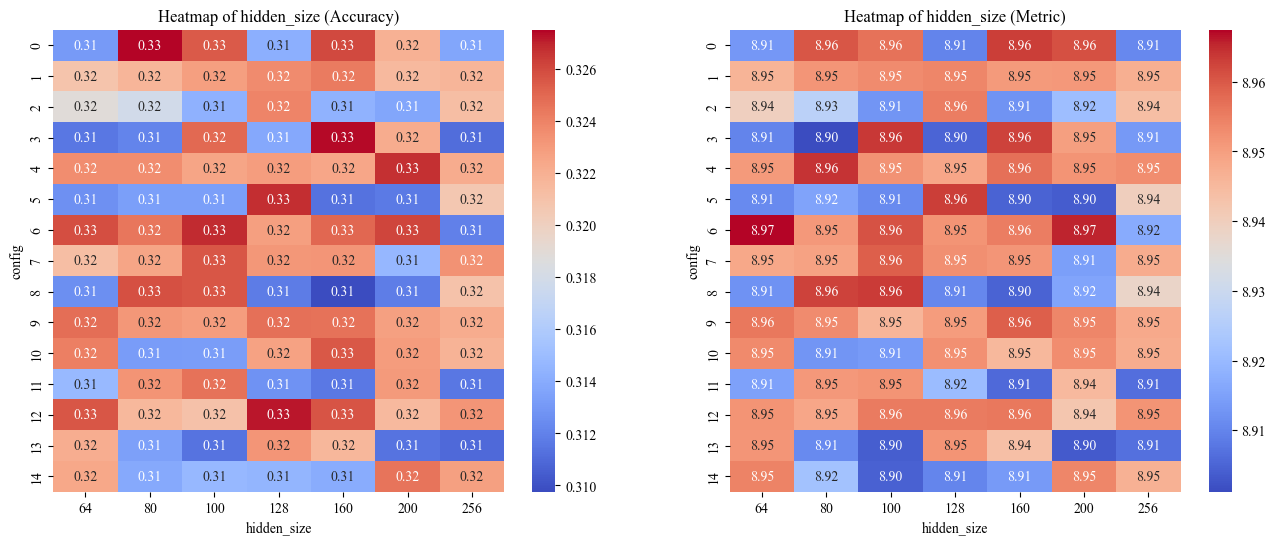

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
hidden_size,,,,,,,
64,0.319605,8.938706,0.003102,0.012810,26.866667,24.533333,7.0
80,0.319826,8.938708,0.003690,0.014746,23.4,21.866667,7.0
100,0.320615,8.940511,0.003302,0.013011,22.866667,20.666667,7.0
128,0.320538,8.939399,0.004288,0.013554,20.0,18.666667,7.0
160,0.320461,8.939071,0.003804,0.014738,18.733333,17.2,7.0
200,0.319760,8.939003,0.004014,0.015470,16.666667,15.733333,7.0
256,0.318625,8.934522,0.003864,0.018202,14.466667,14.6,7.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
44,30,30,31,25,23,28
43,31,31,26,29,29,27
42,30,30,29,25,26,29
41,25,30,27,25,28,28
40,26,26,20,24,28,27
39,23,23,27,24,28,20
38,25,18,18,25,19,19
37,24,20,20,23,23,19
35,17,17,19,14,15,20
34,20,18,21,22,24,20


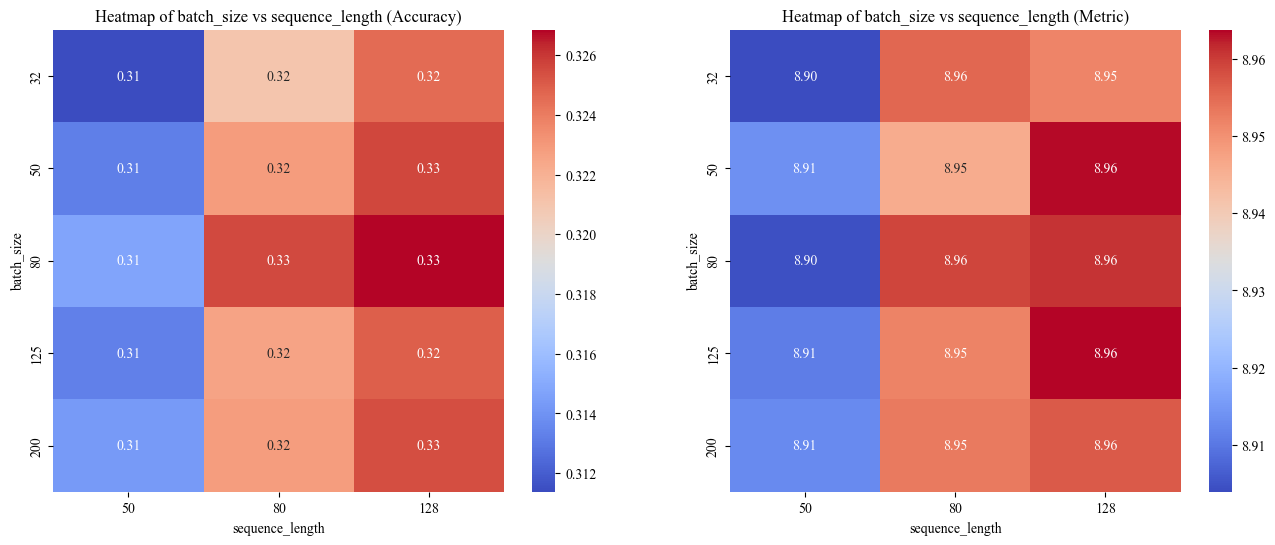

,sequence_length,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
batch_size,,,,,,,
32,86.0,0.318990,8.937070,0.002587,0.016054,19.0,11.0
50,86.0,0.320570,8.940983,0.004543,0.013434,17.0,17.333333
80,86.0,0.322387,8.941467,0.003625,0.012706,23.333333,18.333333
125,86.0,0.320270,8.942207,0.002197,0.013038,24.666667,26.333333
200,86.0,0.320860,8.940827,0.003559,0.009822,30.333333,30.333333


,batch_size,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
sequence_length,,,,,,,
50,97.4,0.313390,8.909106,0.003090,0.012876,21.2,19.4
80,97.4,0.322966,8.953138,0.003112,0.010109,24.4,21.4
128,97.4,0.325490,8.959288,0.003705,0.016047,23.0,21.2


hidden_size: 100
batch_size: 80
sequence_length: 128


In [28]:
tuning_results_path = 'hyperparameter_tuning_results_0217_loads.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'hidden_size'
feature_x = 'batch_size'
feature_y = 'sequence_length'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)
select_df = out_df[out_df[feature]==best_f_val]

best_x_val, best_y_val = df_to_xy_features(select_df, feature_x, feature_y)

print(f'{feature}: {best_f_val}')
print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

In [29]:
select_df[select_df['sequence_length']==128]

,decay,dropout_rate,alpha_value,hidden_size,num_layers,learning_rate,batch_size,sequence_length,best_accuracy,best_metric,...,metric_std,acc_best_epoch,met_best_epoch,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr,dist_details
44,0.00001,0.25,0.8,100,2,0.001,200,128,0.32544,8.95676,...,0.004716,30,30,30,30,31,25,23,28,"[0.32544, 0.7437800000000001, 0.91795999999999..."
41,0.00001,0.25,0.8,100,2,0.001,125,128,0.32495,8.96377,...,0.020319,25,30,25,30,27,25,28,28,"[0.32361000000000006, 0.7485999999999999, 0.92..."
38,0.00001,0.25,0.8,100,2,0.001,80,128,0.32685,8.96078,...,0.017028,25,18,25,18,18,25,19,19,"[0.32661999999999997, 0.7421, 0.92060000000000..."
35,0.00001,0.25,0.8,100,2,0.001,50,128,0.32561,8.96340,...,0.016980,17,17,17,17,19,14,15,20,"[0.32561, 0.74749, 0.9196300000000001, 0.9779,..."
32,0.00001,0.25,0.8,100,2,0.001,32,128,0.32460,8.95173,...,0.021195,18,11,18,11,15,15,12,18,"[0.32167, 0.74071, 0.91794, 0.9779499999999999..."


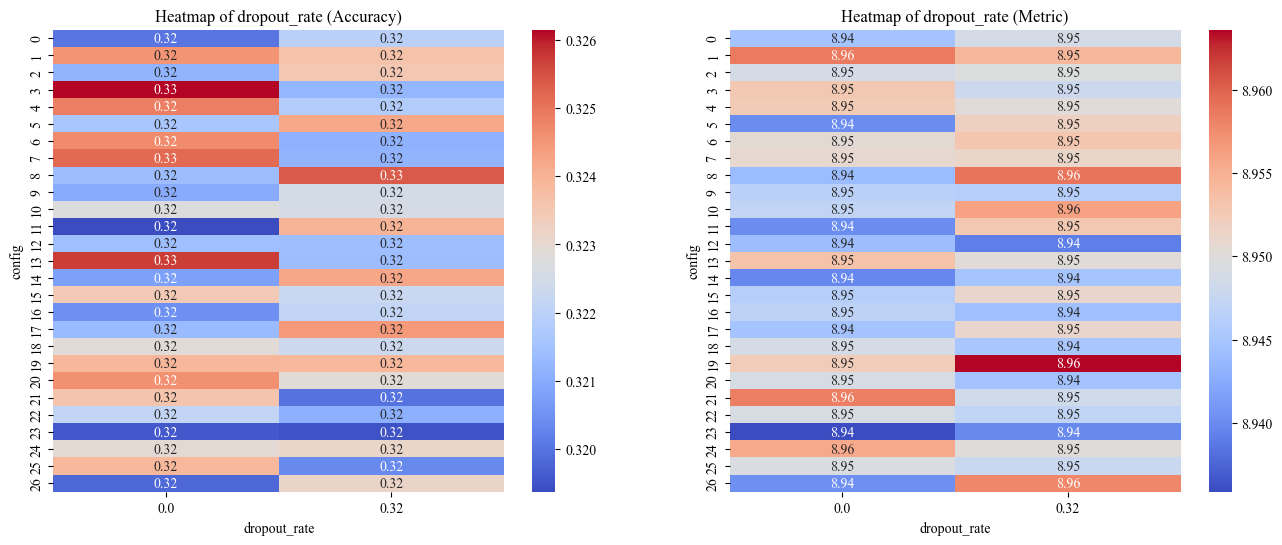

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
dropout_rate,,,,,,,
0.00,0.322563,8.947783,0.004302,0.015818,21.407407,20.0,13.0
0.32,0.322415,8.949849,0.003603,0.011294,22.407407,20.666667,13.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
0,20,19,23,20,19,16
25,19,23,24,19,23,24
24,20,19,22,23,17,15
23,20,21,21,19,19,20
22,24,25,19,16,23,19
21,24,18,20,24,23,16
20,22,18,27,23,25,17
19,17,23,18,18,21,17
18,18,18,22,14,19,19
17,24,16,27,19,19,24


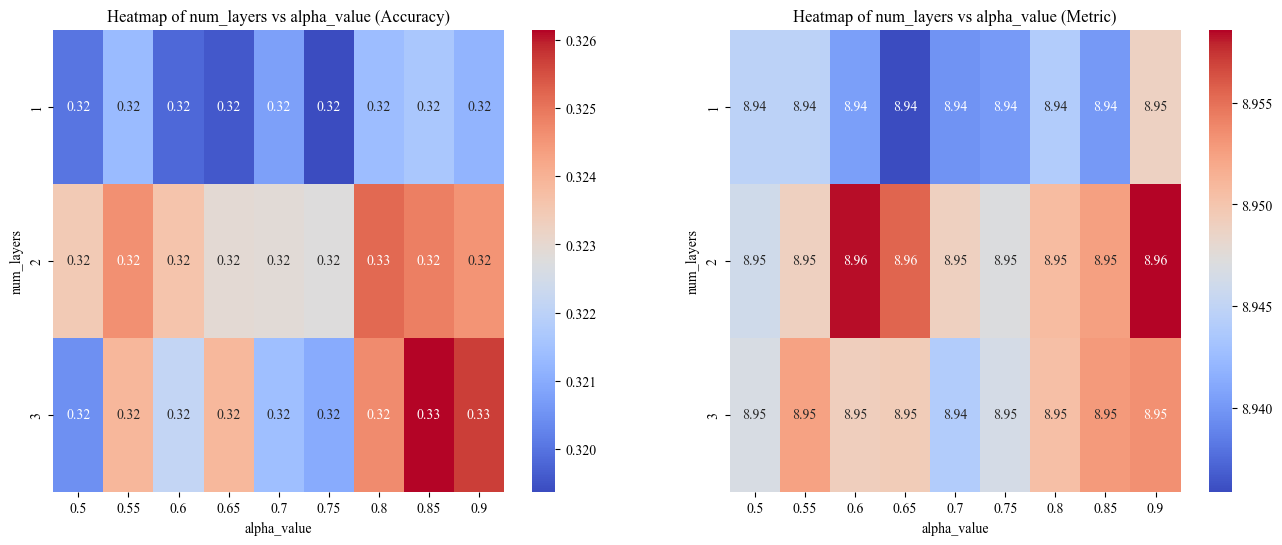

,alpha_value,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
num_layers,,,,,,,
1,0.7,0.320557,8.942048,0.004244,0.013719,19.666667,18.222222
2,0.7,0.323873,8.951872,0.004643,0.017962,22.333333,21.555556
3,0.7,0.323258,8.949428,0.004018,0.015775,22.222222,20.222222


,num_layers,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
alpha_value,,,,,,,
0.50,2.0,0.321320,8.945850,0.003858,0.017787,23.333333,18.666667
0.55,2.0,0.323277,8.948693,0.003474,0.016252,20.666667,20.666667
0.60,2.0,0.321857,8.949307,0.005286,0.009544,23.333333,21.666667
0.65,2.0,0.322123,8.946923,0.004862,0.018749,20.666667,19.666667
0.70,2.0,0.321680,8.944200,0.004290,0.018357,20.666667,17.666667
0.75,2.0,0.321037,8.944583,0.004730,0.019990,22.0,19.333333
0.80,2.0,0.323747,8.948397,0.004095,0.011719,19.0,19.666667
0.85,2.0,0.324220,8.948487,0.003786,0.015677,22.666667,21.333333
0.90,2.0,0.323803,8.953603,0.004333,0.014292,20.333333,21.333333


dropout_rate: 0.0
num_layers: 2
alpha_value: 0.85


In [30]:
tuning_results_path = 'hyperparameter_tuning_results_lay_a_drop.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'dropout_rate'
feature_x = 'num_layers'
feature_y = 'alpha_value'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)
select_df = out_df[out_df[feature]==best_f_val]

best_x_val, best_y_val = df_to_xy_features(select_df, feature_x, feature_y)

print(f'{feature}: {best_f_val}')
print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

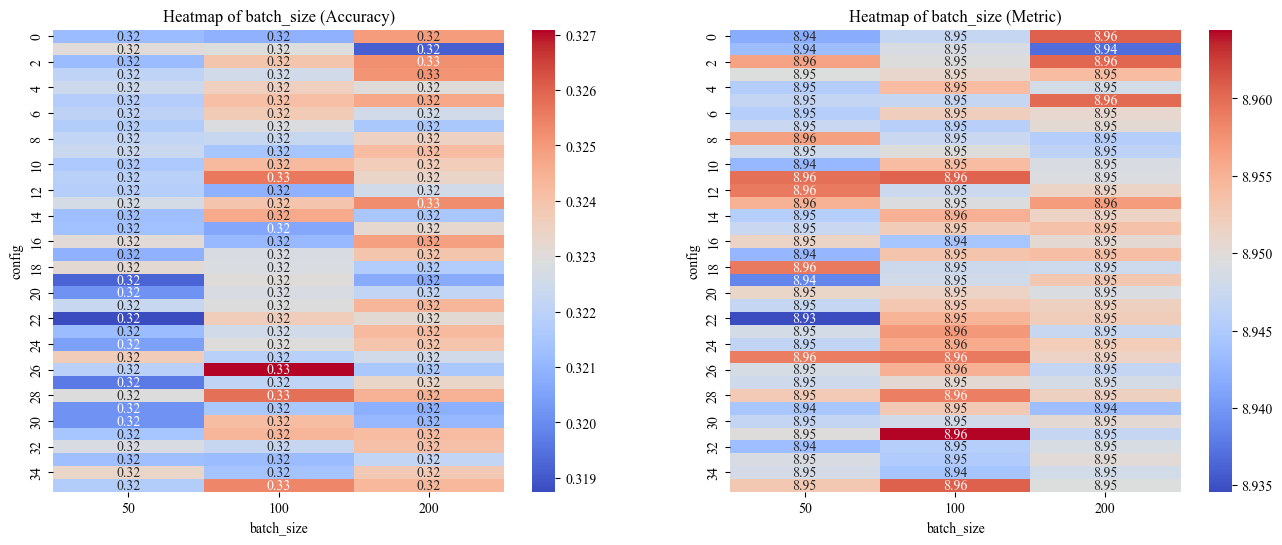

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
batch_size,,,,,,,
50,0.321635,8.948699,0.004588,0.014693,16.583333,15.444444,17.5
100,0.323060,8.951691,0.003763,0.013161,22.638889,21.222222,17.5
200,0.323200,8.950500,0.003842,0.014377,28.972222,28.083333,17.5


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
92,31,29,29,31,26,26
86,30,25,26,22,27,26
104,29,29,28,28,31,26
83,29,29,30,30,28,31
95,25,29,29,25,31,28
101,26,26,28,28,24,27
98,31,31,26,30,29,27
89,24,24,29,27,28,28
53,31,29,28,31,29,26
77,27,30,29,29,30,27


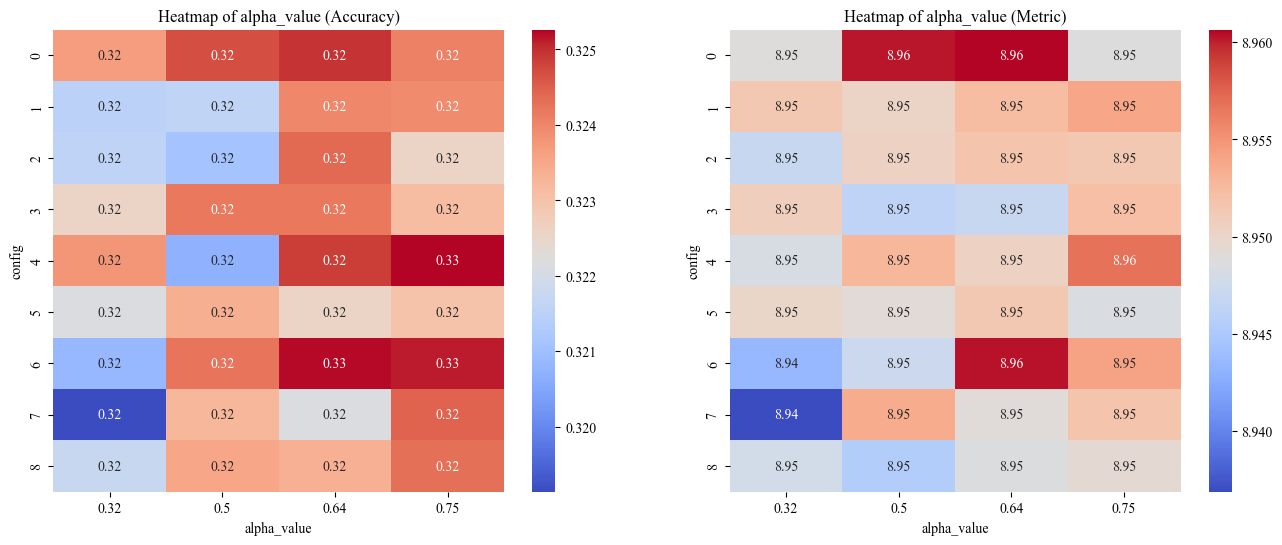

,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch,config
alpha_value,,,,,,,
0.32,0.321886,8.947166,0.004046,0.014530,29.0,28.666667,4.0
0.50,0.322967,8.950598,0.003902,0.014482,29.0,28.222222,4.0
0.64,0.323962,8.952382,0.004155,0.014483,29.333333,28.666667,4.0
0.75,0.323984,8.951854,0.003266,0.014012,28.555556,26.777778,4.0


,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr
71,28,29,26,26,30,30
23,29,24,26,29,24,23
47,29,26,28,29,30,28
35,28,22,26,29,30,31
11,30,30,27,27,31,20
95,25,29,29,25,31,28
83,29,29,30,30,28,31
59,30,29,26,30,31,26
107,29,23,31,29,24,22


C:\Users\Jim\AppData\Local\Temp\ipykernel_17176\669966004.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_df = select_df[out_df[feature_2]==best_f_val_2]


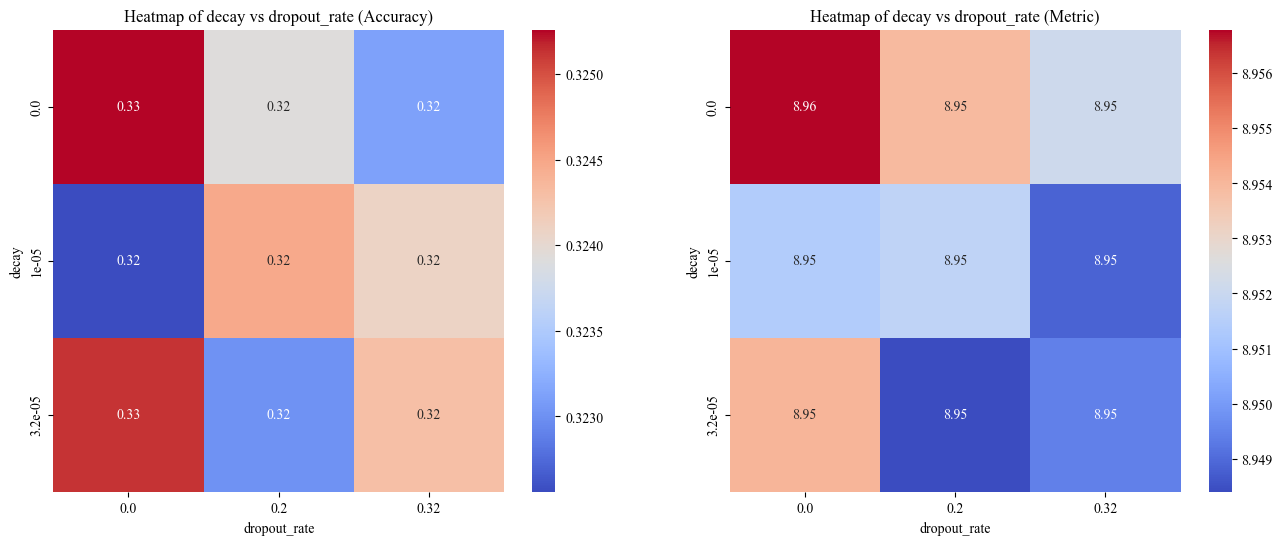

,dropout_rate,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
decay,,,,,,,
0.000000,0.173333,0.324103,8.954280,0.002449,0.013043,29.0,25.333333
0.000010,0.173333,0.323703,8.950657,0.004070,0.017100,29.0,28.0
0.000032,0.173333,0.324147,8.950627,0.003278,0.011892,27.666667,27.0


,decay,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
dropout_rate,,,,,,,
0.00,0.000014,0.324317,8.954083,0.003387,0.014273,29.333333,28.333333
0.20,0.000014,0.323803,8.951353,0.003658,0.014301,28.0,27.333333
0.32,0.000014,0.323833,8.950127,0.002751,0.013461,28.333333,24.666667


batch_size: 200
alpha_value: 0.75
decay: 3.2e-05
dropout_rate: 0.0


In [31]:
tuning_results_path = 'hyperparameter_tuning_results_batch_a_drop_dec.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature = 'batch_size'
feature_2 = 'alpha_value'
feature_x = 'decay'
feature_y = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)
select_df = out_df[out_df[feature]==best_f_val].sort_values(by=feature_2)

best_f_val_2 = df_to_i_feature(select_df, feature_2)
select_df = select_df[out_df[feature_2]==best_f_val_2]

best_x_val, best_y_val = df_to_xy_features(select_df, feature_x, feature_y)

print(f'{feature}: {best_f_val}')
print(f'{feature_2}: {best_f_val_2}')
print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

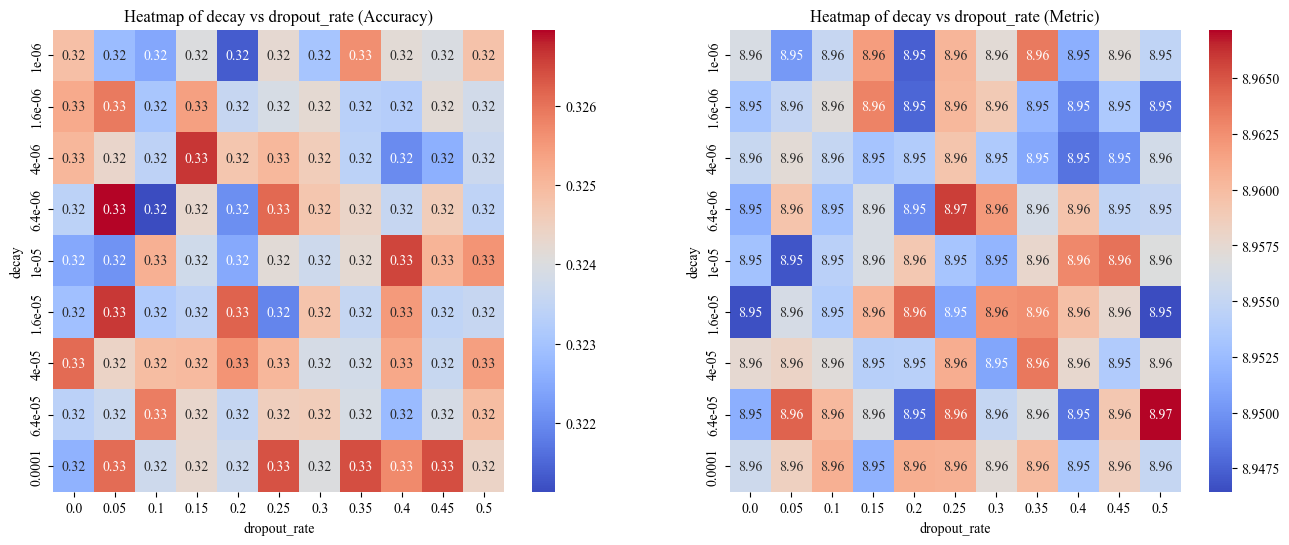

,dropout_rate,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
decay,,,,,,,
0.000001,0.25,0.323761,8.955959,0.004294,0.012609,21.636364,19.363636
0.000002,0.25,0.324169,8.954396,0.003397,0.017255,21.818182,20.363636
0.000004,0.25,0.324134,8.953912,0.004932,0.013484,21.636364,20.090909
0.000006,0.25,0.324065,8.956639,0.004150,0.013952,21.454545,21.636364
0.000010,0.25,0.324114,8.956017,0.004476,0.012362,21.727273,19.363636
0.000016,0.25,0.324104,8.956438,0.004299,0.015265,22.545455,20.181818
0.000040,0.25,0.324817,8.956846,0.003362,0.012874,22.727273,21.363636
0.000064,0.25,0.324125,8.957440,0.003761,0.012848,23.272727,22.454545
0.000100,0.25,0.324885,8.957469,0.003453,0.011508,26.272727,25.181818


,decay,best_accuracy,best_metric,accuracy_std,metric_std,acc_best_epoch,met_best_epoch
dropout_rate,,,,,,,
0.00,0.000027,0.324007,8.953421,0.003872,0.012383,24.0,21.444444
0.05,0.000027,0.324767,8.956234,0.004293,0.013184,21.111111,20.666667
0.10,0.000027,0.323658,8.956261,0.004529,0.013318,22.666667,21.444444
0.15,0.000027,0.324568,8.957101,0.005127,0.014314,21.444444,19.444444
0.20,0.000027,0.323692,8.953862,0.003178,0.014111,22.777778,22.0
0.25,0.000027,0.324588,8.959570,0.004431,0.011712,22.444444,21.777778
0.30,0.000027,0.324169,8.956612,0.003206,0.015500,22.111111,20.333333
0.35,0.000027,0.324297,8.958166,0.003751,0.012173,22.777778,21.444444
0.40,0.000027,0.324314,8.954532,0.004749,0.014302,23.666667,21.222222


decay: 0.0001
dropout_rate: 0.05


In [32]:
tuning_results_path = 'hyperparameter_tuning_results_0217_reg.csv'
tuning_results_path = 'asset/csv/' + tuning_results_path
feature_x = 'decay'
feature_y = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

In [33]:
tops = 20

best_acc_ind = np.argsort(out_df.best_accuracy).tolist()[-tops:]
print(best_acc_ind)
#display(out_df.iloc[best_acc_ind,:])

best_ovr_ind = np.argsort(out_df.best_metric).tolist()[-tops:]
print(best_ovr_ind)
#display(out_df.iloc[best_ovr_ind,:])

reg_df = out_df[['decay','dropout_rate','best_accuracy','best_metric']]
reg_df.iloc[list(set(best_ovr_ind).intersection(set(best_acc_ind)))]

[14, 76, 63, 54, 70, 7, 96, 79, 12, 89, 66, 38, 59, 93, 97, 95, 52, 56, 25, 34]
[5, 58, 93, 90, 92, 71, 3, 39, 61, 62, 52, 14, 7, 73, 53, 59, 82, 78, 38, 87]


,decay,dropout_rate,best_accuracy,best_metric
38,0.000006,0.25,0.32612,8.96585
7,0.000001,0.35,0.32566,8.96352
14,0.000002,0.15,0.32540,8.96306
52,0.000010,0.40,0.32652,8.96286
59,0.000016,0.20,0.32620,8.96409
93,0.000100,0.25,0.32638,8.96064
